In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text, num_show=1):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    if i == num_show:
      break
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/new/temp/textsum/model.seq2seq.attention.luong'
predictor = melt.Predictor(model_dir)

def inference(text, num_show=1):
  predict(predictor, text, num_show=num_show)

ENCODE_UNK 1
restore from /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000


import graph ok /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000.meta
restore ok /home/gezi/new/temp/textsum/model.seq2seq.attention.luong/model.ckpt-6.8-571000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5143, 5088, 7316, 532, 13, 691, 742, 805, 5143, 5088, 7316, 532, 13, 11810, 16506, 0, 0, 0, 0, 0] len: 20
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
0 [2893, 3701, 1] 蔬菜/种植/<EOS> 0.00955107477246 -4.6511 -4.6511 [-2.276756, -1.3827589, -0.99158651]


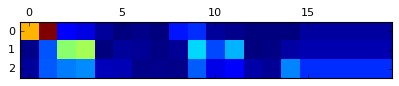

beam search using time(ms): 962.445020676
word_ids [214, 899, 322, 1866, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球/吗
你/去/打/篮球/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.096131690908 -2.34204 -2.34204 [-0.65660387, -0.0065855617, -1.6788467]


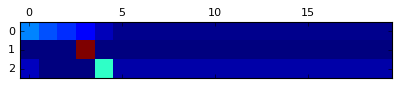

beam search using time(ms): 256.08587265
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.066580586276 -2.70934 -2.70934 [-0.86926389, -0.0090493541, -1.8310291]


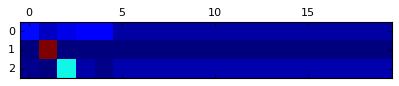

beam search using time(ms): 260.673999786
word_ids [1492, 210, 267, 244, 655, 8, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [267, 244, 655, 1] 周/华/健/<EOS> 0.190454128027 -1.65834 -1.65834 [-0.28877574, -0.14913641, -0.043803614, -1.1766281]


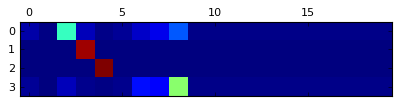

beam search using time(ms): 278.081893921
word_ids [25394, 84, 2743, 19, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [19, 807, 752, 1] 高/晓/松/<EOS> 0.0406965581162 -3.20161 -3.20161 [-1.9274502, -0.42321333, -0.11868184, -0.73226643]


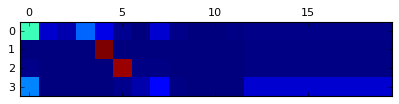

beam search using time(ms): 244.354009628
word_ids [60, 811, 2742, 235, 949, 3383, 60, 811, 2742, 2841, 1679, 57, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
0 [60, 811, 2742, 503, 57, 1] 王/凯/整容/前/照片/<EOS> 0.0573600335719 -2.85841 -2.85841 [-0.60604089, -0.0098575465, -0.19275108, -1.0899825, -0.87254107, -0.087234415]


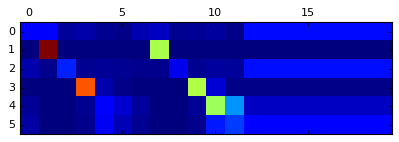

beam search using time(ms): 263.439893723
word_ids [6423, 1083, 5327, 226, 24332, 668, 668, 163, 13, 4073, 62, 107, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
0 [163, 62, 107, 1] 性感/黑/丝/<EOS> 0.01322253951 -4.32583 -4.32583 [-1.1990755, -1.3381264, -0.011833117, -1.7767972]


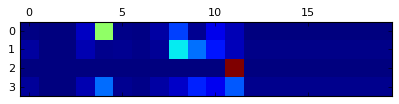

beam search using time(ms): 257.36117363
word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0209531934864 -3.86546 -3.86546 [-2.1592665, -0.18988812, -1.5163097]


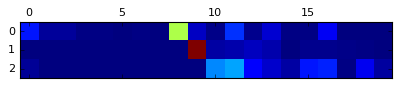

beam search using time(ms): 249.998092651
word_ids [37, 14356, 7, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 14356, 1] 美女/劈叉/<EOS> 0.0142862953158 -4.24845 -4.24845 [-0.48869628, -3.0127354, -0.74702275]


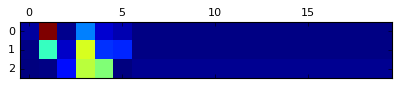

beam search using time(ms): 244.785070419
word_ids [1817, 7, 1252, 228, 7, 4006, 228, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
》/ /卫生/间/ /洗手/间/ 
》/ /卫生/间/ /洗手/间/ 
0 [1252, 228, 4006, 228, 1] 卫生/间/洗手/间/<EOS> 0.081863250784 -2.50271 -2.50271 [-0.81431478, -0.015170315, -0.55678809, -0.15636835, -0.96006346]


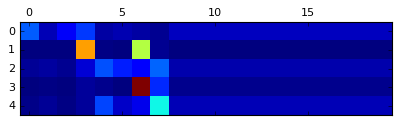

beam search using time(ms): 269.613027573
word_ids [2234, 7, 3885, 4193, 828, 146, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
iphone/ /6s/耐克/主题/手机/壁纸
iphone/ /6s/耐克/主题/手机/壁纸
0 [3885, 146, 30, 1] 6s/手机/壁纸/<EOS> 0.0127215655146 -4.36446 -4.36446 [-1.5603054, -1.0904219, -0.56205285, -1.1516768]


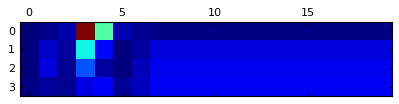

beam search using time(ms): 250.036001205


In [8]:
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
predict(predictor, '你去打篮球吗')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('年少不懂高晓松,读懂已不再少年')
inference('王凯整容了吗_王凯整容前后对比照片')
inference('【贴图】韩敏英--性感小吊带黑丝')
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看')
inference('美女劈叉 鼻血狂喷')
inference('》 卫生间 洗手间 ')
inference('iphone 6s耐克主题手机壁纸')

word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
0 [1298, 426, 775, 448, 1] 赵丽/颖/古装/剧照/<EOS> 0.0904333454662 -2.40314 -2.40314 [-0.2888431, -0.000915704, -0.44250178, -1.3284128, -0.34246892]


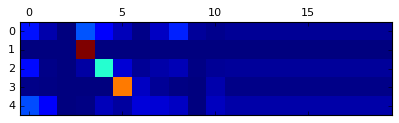

beam search using time(ms): 255.420923233


In [9]:
inference('蜀山战纪赵丽颖古装剧照(12张) ')

word_ids [323, 56, 758, 45, 301, 9147, 1733, 410, 570, 1100, 8, 6091, 1817, 0, 0, 0, 0, 0, 0, 0] len: 20
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
0 [323, 56, 45, 301, 758, 1] 幼儿/园/简/笔画/动物/<EOS> 0.0105727616649 -4.54947 -4.54947 [-1.0154142, -0.21651831, -1.2958692, -0.027217913, -1.2525972, -0.74185735]


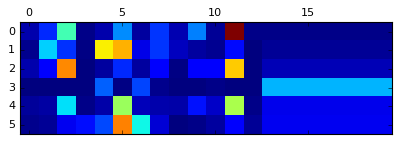

beam search using time(ms): 246.584892273


In [10]:
inference('幼儿园动物简笔画教案《两条漂亮的小鱼》')

word_ids [334, 595, 85, 1034, 11, 5593, 121, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
第/六/感/美甲/美/睫/纹/秀
第/六/感/美甲/美/睫/纹/秀
0 [1034, 11, 5593, 1] 美甲/美/睫/<EOS> 0.0314295510038 -3.46001 -3.46001 [-0.39742136, -1.4043508, -0.41861746, -1.2396171]


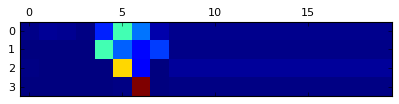

beam search using time(ms): 266.176939011


In [11]:
inference('第六感美甲美睫纹秀')

word_ids [4305, 5762, 3136, 5697, 2060, 389, 1961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
2013/春夏/男装/米兰/时装/秀/9
2013/春夏/男装/米兰/时装/秀/9
0 [2060, 389, 1] 时装/秀/<EOS> 0.0398101533736 -3.22363 -3.22363 [-1.8280451, -0.018203575, -1.3773844]


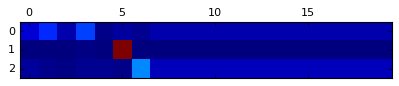

beam search using time(ms): 239.30478096


In [12]:
inference('2013春夏男装米兰时装秀9')

word_ids [772, 7630, 67, 89652, 8, 19841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
关于/房价/最/透彻/的/解读
关于/房价/最/透彻/的/解读
0 [7630, 18755, 1] 房价/上涨/<EOS> 0.0117920405429 -4.44033 -4.44033 [-2.2276981, -1.6943672, -0.51826549]


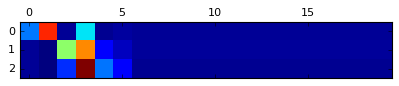

beam search using time(ms): 254.498004913


In [13]:
inference('关于房价最透彻的解读')

word_ids [4667, 630, 7902, 51, 1297, 10515, 4961, 7170, 16504, 3467, 25032, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
0 [10515, 4961, 1] 职称/制度/<EOS> 0.00240857406978 -6.02872 -6.02872 [-3.6764708, -1.8607087, -0.49154103]


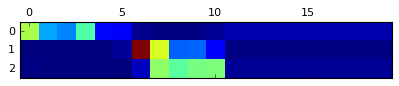

beam search using time(ms): 266.722917557


In [14]:
inference('辽宁省中小学教师职称制度改革实施方案出台')

word_ids [4470, 452, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
骷髅/情侣/纹身
骷髅/情侣/纹身
0 [4470, 208, 1] 骷髅/纹身/<EOS> 0.0276562444342 -3.5879 -3.5879 [-1.9083782, -0.81976724, -0.8597582]


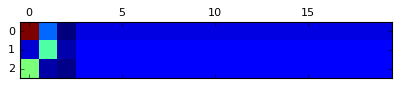

beam search using time(ms): 242.696046829


In [15]:
inference('骷髅情侣纹身')

word_ids [42999, 869, 1474, 363, 8, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0689416199511 -2.6745 -2.6745 [-0.60090029, -0.0024729169, -0.0023142719, -2.0688078]


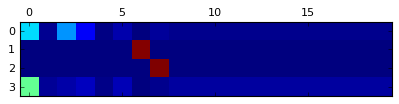

酷似/朴/姬/兰/的/刘/亦/菲
1 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.021015641823 -3.86249 -3.86249 [-0.60090029, -0.0024729169, -0.0023142719, -2.7309277, -0.52587306]


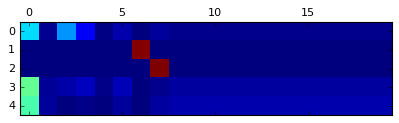

酷似/朴/姬/兰/的/刘/亦/菲
2 [20, 1] <UNK>/<EOS> 0.0131902658455 -4.32828 -4.32828 [-3.7151561, -0.6131202]


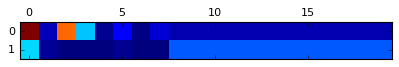

酷似/朴/姬/兰/的/刘/亦/菲
3 [164, 926, 649, 57, 1] 刘/亦/菲/照片/<EOS> 0.00565861945633 -5.17458 -5.17458 [-0.60090029, -0.0024729169, -0.0023142719, -4.152194, -0.41669351]


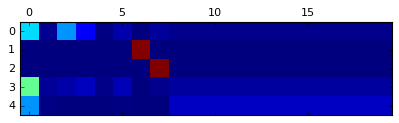

酷似/朴/姬/兰/的/刘/亦/菲
4 [164, 926, 649, 319, 1] 刘/亦/菲/写真/<EOS> 0.00506656666591 -5.28509 -5.28509 [-0.60090029, -0.0024729169, -0.0023142719, -3.9398367, -0.73956758]


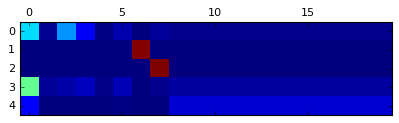

酷似/朴/姬/兰/的/刘/亦/菲
5 [164, 926, 649, 164, 926, 649, 1] 刘/亦/菲/刘/亦/菲/<EOS> 0.00390579361908 -5.54529 -5.54529 [-0.60090029, -0.0024729169, -0.0023142719, -3.9302332, -0.0040810169, -0.00155233, -1.0037404]


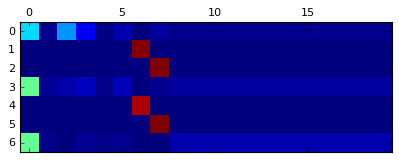

酷似/朴/姬/兰/的/刘/亦/菲
6 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.00281410700705 -5.87311 -5.87311 [-3.9738412, -0.080788642, -1.0656809, -0.75279957]


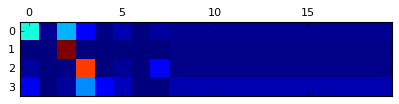

酷似/朴/姬/兰/的/刘/亦/菲
7 [869, 1474, 1] 朴/姬/<EOS> 0.00254163685169 -5.97495 -5.97495 [-3.9738412, -0.080788642, -1.9203171]


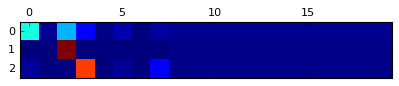

酷似/朴/姬/兰/的/刘/亦/菲
8 [164, 926, 649, 7, 319, 1] 刘/亦/菲/ /写真/<EOS> 0.00225285339725 -6.09556 -6.09556 [-0.60090029, -0.0024729169, -0.0023142719, -2.5139582, -2.505821, -0.47009155]


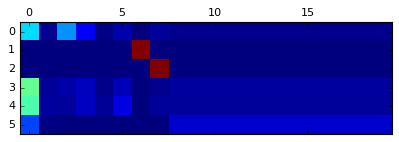

酷似/朴/姬/兰/的/刘/亦/菲
9 [1474, 363, 1] 姬/兰/<EOS> 0.0022477232856 -6.09784 -6.09784 [-4.9632316, -0.20018679, -0.93441892]


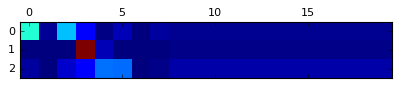

beam search using time(ms): 1399.38306808


In [24]:
inference('酷似朴姬兰的刘亦菲', 10)

word_ids [42999, 164, 926, 649, 8, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0475892278281 -3.04515 -3.04515 [-1.050153, -0.006190293, -0.0041780095, -1.9846275]


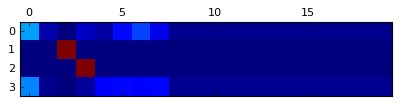

酷似/刘/亦/菲/的/朴/姬/兰
1 [20, 1] <UNK>/<EOS> 0.0201227541962 -3.9059 -3.9059 [-3.3266222, -0.57928187]


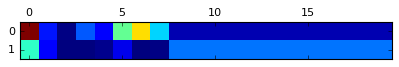

酷似/刘/亦/菲/的/朴/姬/兰
2 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.0155482912929 -4.1638 -4.1638 [-1.050153, -0.006190293, -0.0041780095, -2.7304227, -0.37286031]


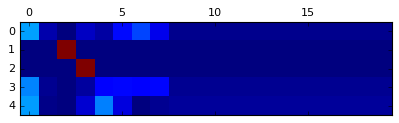

酷似/刘/亦/菲/的/朴/姬/兰
3 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.0109538549424 -4.51406 -4.51406 [-2.8421929, -0.047058381, -0.9134329, -0.71138]


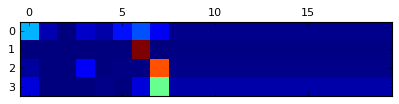

酷似/刘/亦/菲/的/朴/姬/兰
4 [869, 1474, 1] 朴/姬/<EOS> 0.0084918035442 -4.76865 -4.76865 [-2.8421929, -0.047058381, -1.8794029]


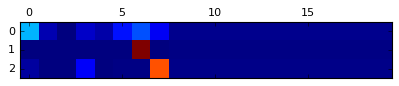

beam search using time(ms): 590.829133987


In [17]:
inference('酷似刘亦菲的朴姬兰', 5)

word_ids [97, 80, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
我/爱/打/篮球
我/爱/打/篮球
0 [322, 1866, 1] 打/篮球/<EOS> 0.0391312181272 -3.24083 -3.24083 [-1.5456082, -0.0061348462, -1.6890918]


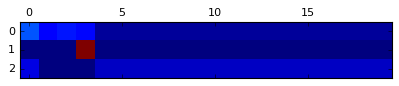

beam search using time(ms): 225.339889526


In [18]:
inference('我爱打篮球')

word_ids [322, 1866, 181, 84, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/好/不/好
打/篮球/好/不/好
0 [322, 1866, 1] 打/篮球/<EOS> 0.0380596556821 -3.2686 -3.2686 [-1.3900776, -0.0058805551, -1.8726424]


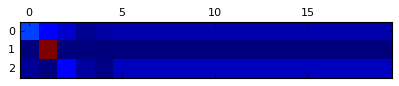

beam search using time(ms): 230.14497757


In [19]:
inference('打篮球好不好')

word_ids [27135, 7, 1614, 6577, 8, 157, 10898, 21077, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
0 [20, 1] <UNK>/<EOS> 0.0155836963367 -4.16153 -4.16153 [-3.674087, -0.48744279]


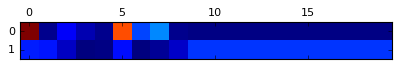

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
1 [157, 10898, 1] 南/美洲/<EOS> 0.0125418941565 -4.37868 -4.37868 [-2.4753003, -0.050797064, -1.8525833]


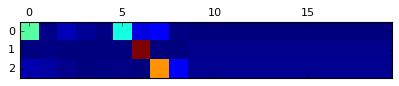

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
2 [157, 10898, 6, 1] 南/美洲/图片/<EOS> 0.00189774237956 -6.26709 -6.26709 [-2.4753003, -0.050797064, -3.542109, -0.19888401]


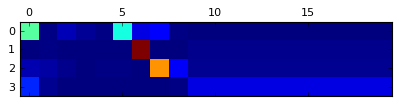

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
3 [9525, 1] 夏威夷/<EOS> 0.00173148459248 -6.35878 -6.35878 [-4.0814919, -2.2772844]


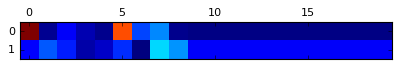

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
4 [157, 10898, 10258, 1] 南/美洲/群岛/<EOS> 0.00124954640389 -6.68497 -6.68497 [-2.4753003, -0.050797064, -2.7171435, -1.4417338]


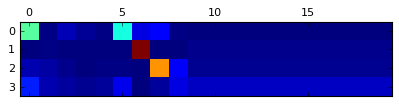

beam search using time(ms): 620.345115662


In [20]:
inference('厄瓜多尔 美丽神秘的南美洲国度 ', 5)

word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0209531884908 -3.86546 -3.86546 [-2.1592665, -0.18988802, -1.51631]


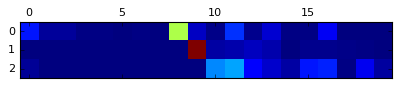

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
1 [1672, 485, 3243, 16400, 670, 1] 彭/于/晏/寒战/2/<EOS> 0.0121801810035 -4.40795 -4.40795 [-1.9980432, -0.0035636034, -0.064464472, -0.81229103, -0.71439886, -0.815184]


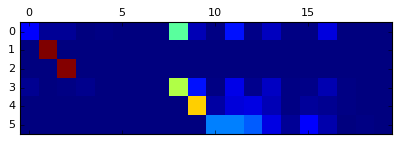

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
2 [20, 1] <UNK>/<EOS> 0.00758386386988 -4.88173 -4.88173 [-4.2523413, -0.62939119]


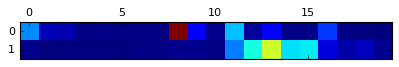

beam search using time(ms): 412.487983704


In [21]:
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看', 3)

word_ids [164, 926, 649, 210, 164, 3144, 8, 1213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
刘/亦/菲/是/刘/诗诗/的/朋友
刘/亦/菲/是/刘/诗诗/的/朋友
0 [164, 926, 649, 164, 926, 649, 1] 刘/亦/菲/刘/亦/菲/<EOS> 0.0570209797092 -2.86434 -2.86434 [-0.030430127, -0.084550127, -0.0017682168, -1.16663, -0.28756943, -0.0016098171, -1.2917783]


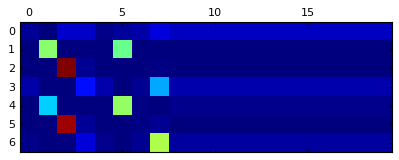

刘/亦/菲/是/刘/诗诗/的/朋友
1 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0311763408031 -3.4681 -3.4681 [-0.030430127, -0.084550127, -0.0017682168, -3.3513472]


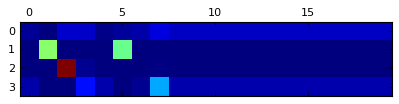

刘/亦/菲/是/刘/诗诗/的/朋友
2 [164, 926, 649, 7, 164, 926, 649, 1] 刘/亦/菲/ /刘/亦/菲/<EOS> 0.0220866630633 -3.81278 -3.81278 [-0.030430127, -0.084550127, -0.0017682168, -2.6466668, -0.52187729, -0.11485574, -0.00097310863, -0.41165972]


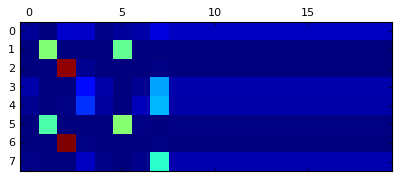

beam search using time(ms): 504.365205765


In [33]:
inference('刘亦菲是刘诗诗的朋友', 3)

word_ids [88, 1231, 1398, 42999, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
张/柏/芝/酷似/刘/亦/菲
张/柏/芝/酷似/刘/亦/菲
0 [164, 926, 649, 88, 1231, 1398, 1] 刘/亦/菲/张/柏/芝/<EOS> 0.031440493256 -3.45966 -3.45966 [-0.70830119, -0.0025198869, -0.001623504, -1.7779262, -0.049432281, -0.014561454, -0.90529412]


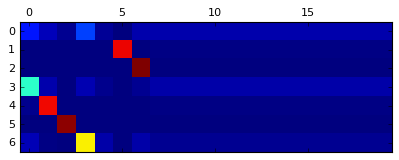

张/柏/芝/酷似/刘/亦/菲
1 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0203200973194 -3.89614 -3.89614 [-0.70830119, -0.0025198869, -0.001623504, -3.1837003]


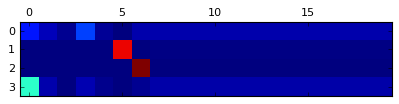

张/柏/芝/酷似/刘/亦/菲
2 [88, 1231, 1398, 1] 张/柏/芝/<EOS> 0.0170446571576 -4.07192 -4.07192 [-1.2349449, -0.021773579, -0.013937172, -2.8012629]


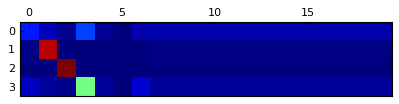

beam search using time(ms): 498.916149139


In [31]:
inference('张柏芝酷似刘亦菲', 3)

word_ids [210, 164, 926, 649, 84, 210, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
是/刘/亦/菲/不/是/朴/姬/兰
是/刘/亦/菲/不/是/朴/姬/兰
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.039606363164 -3.22877 -3.22877 [-1.0114243, -0.0059977551, -0.0030657693, -2.2082775]


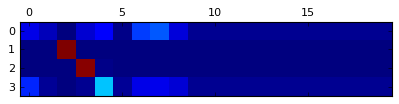

是/刘/亦/菲/不/是/朴/姬/兰
1 [164, 926, 649, 6, 1] 刘/亦/菲/图片/<EOS> 0.0128463346363 -4.3547 -4.3547 [-1.0114243, -0.0059977551, -0.0030657693, -2.8507164, -0.4834922]


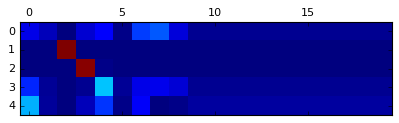

是/刘/亦/菲/不/是/朴/姬/兰
2 [20, 1] <UNK>/<EOS> 0.0125625316784 -4.37704 -4.37704 [-3.8793261, -0.49771059]


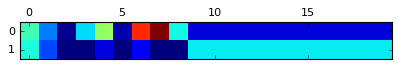

beam search using time(ms): 515.805959702


In [34]:
inference('是刘亦菲不是朴姬兰', 3)

word_ids [210, 88, 1231, 1398, 84, 210, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
是/张/柏/芝/不/是/刘/亦/菲
是/张/柏/芝/不/是/刘/亦/菲
0 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0203802214763 -3.89319 -3.89319 [-0.89004534, -0.0021301454, -0.0017056216, -2.9993093]


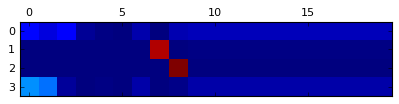

是/张/柏/芝/不/是/刘/亦/菲
1 [88, 1231, 1398, 1] 张/柏/芝/<EOS> 0.0132985748967 -4.3201 -4.3201 [-1.4849637, -0.024790976, -0.018560776, -2.7917829]


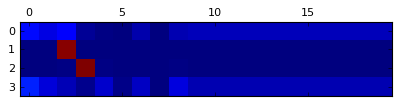

是/张/柏/芝/不/是/刘/亦/菲
2 [164, 926, 649, 88, 1231, 1398, 1] 刘/亦/菲/张/柏/芝/<EOS> 0.0109506118122 -4.51436 -4.51436 [-0.89004534, -0.0021301454, -0.0017056216, -2.555104, -0.064079136, -0.016432311, -0.98486364]


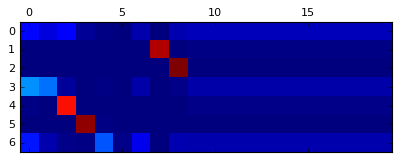

beam search using time(ms): 511.723041534


In [36]:
inference('是张柏芝不是刘亦菲', 3)